# Image Segmentation using TensorFlow

In [1]:
import datetime
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose
    )
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}


In [4]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [6]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [7]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [8]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [9]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [10]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

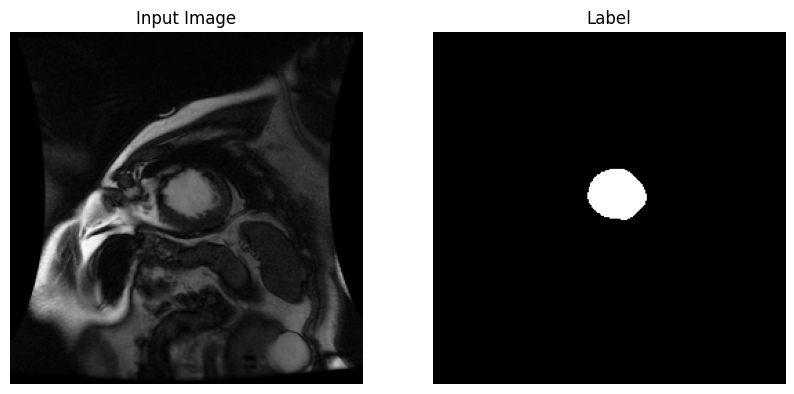

In [11]:
# display an image and label from the training set
for image, label in train.take(1):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

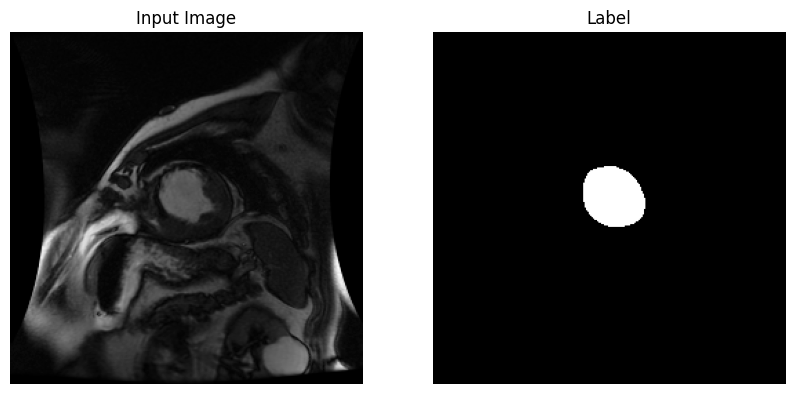

In [12]:
# display an image and label from the test set
for image, label in val.take(1):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

# Fully-connected NN with one hidden layer


In [13]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

g:\Desktop\Project\LLMHobbyProjects\ImageSegmentation\myenv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │     8,519,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,714,048 (48.50 MB)

 Trainable params: 12,714,048 (48.50 MB)

 Non-trainable params: 0 (0.00 B)

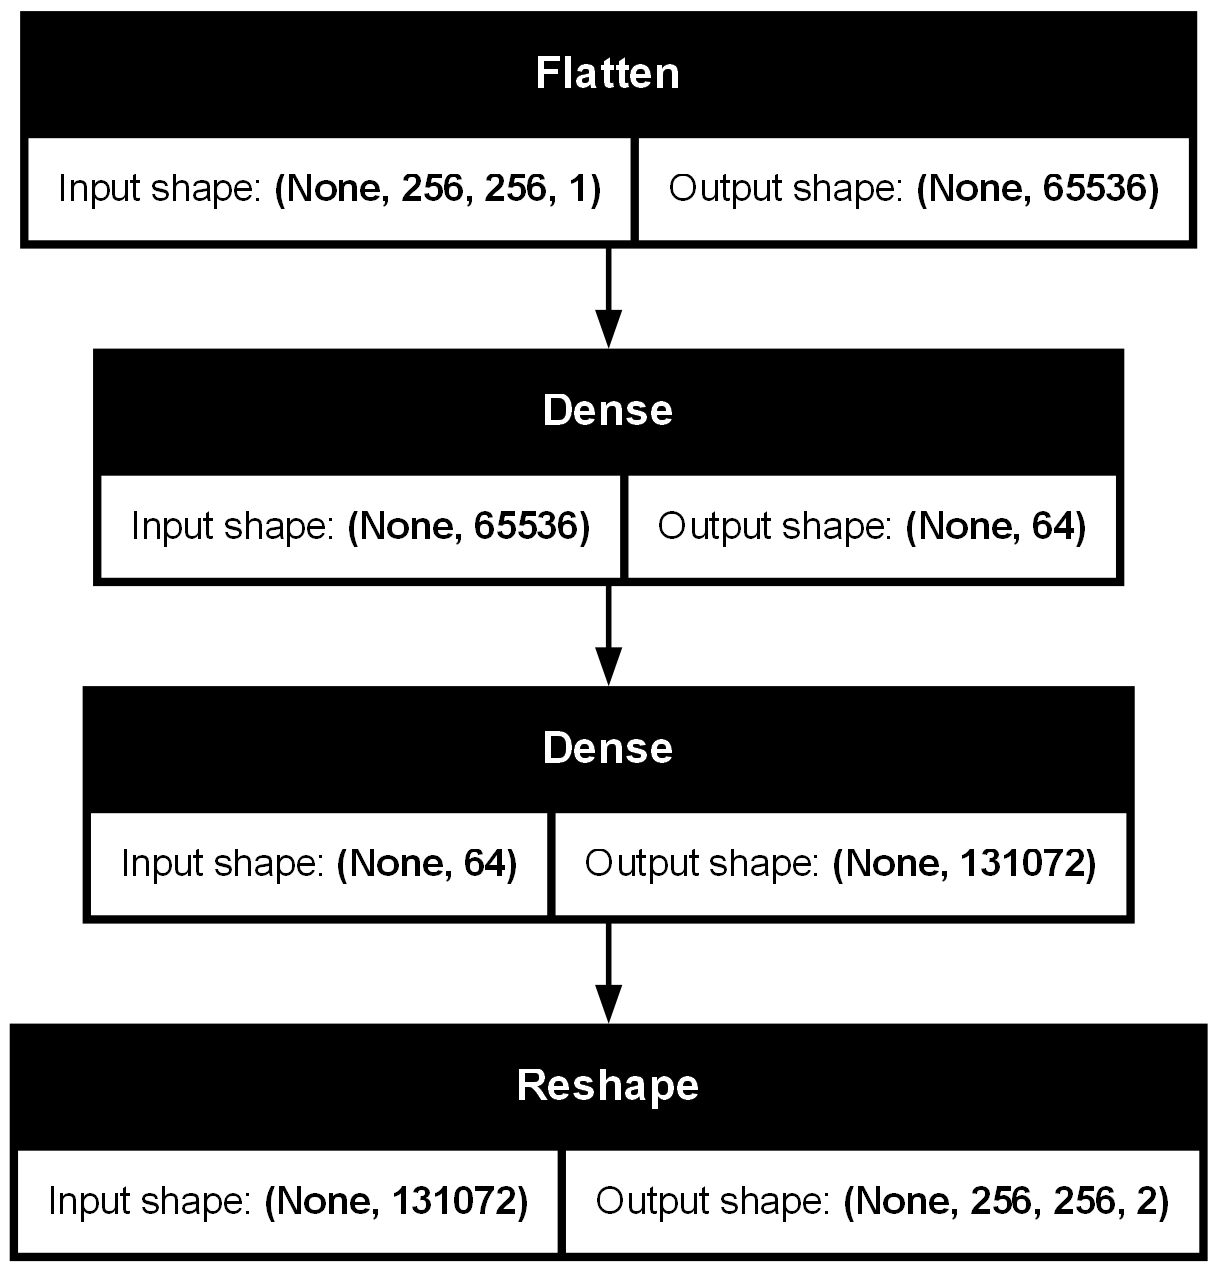

In [15]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [17]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


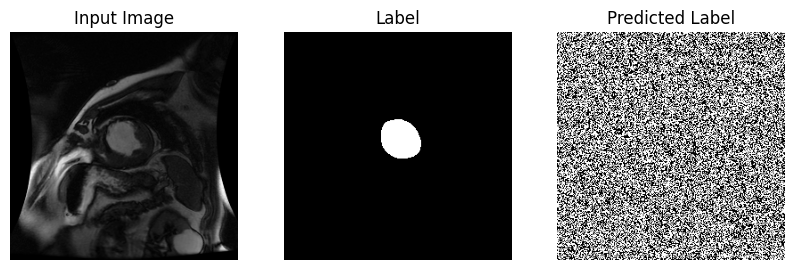

In [18]:
# show a predection, as an example
show_predictions(test_dataset)

In [19]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step/step - accuracy: 0.5004 - loss: 0.693


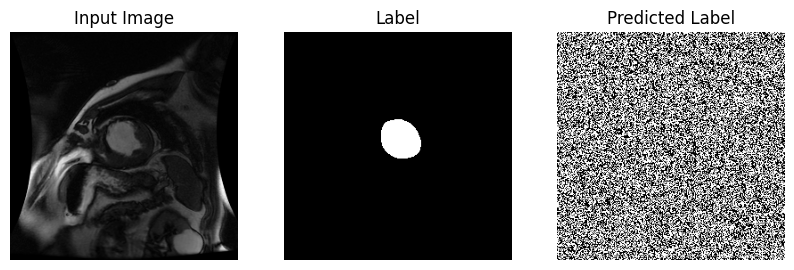


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 100s 415ms/step - accuracy: 0.5004 - loss: 0.6931 - val_accuracy: 0.5091 - val_loss: 0.6931
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepms/step - accuracy: 0.5137 - loss: 0.693


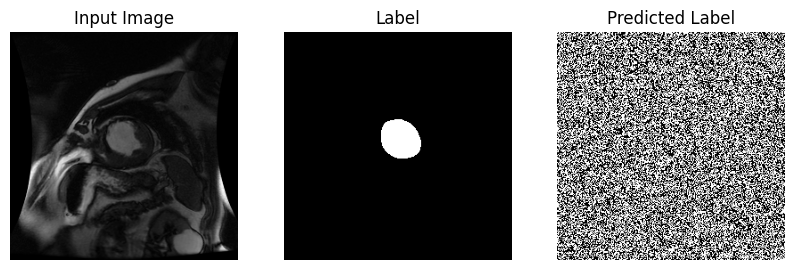


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 203s 819ms/step - accuracy: 0.5137 - loss: 0.6931 - val_accuracy: 0.5273 - val_loss: 0.6931
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/stepstep - accuracy: 0.5330 - loss: 0.69


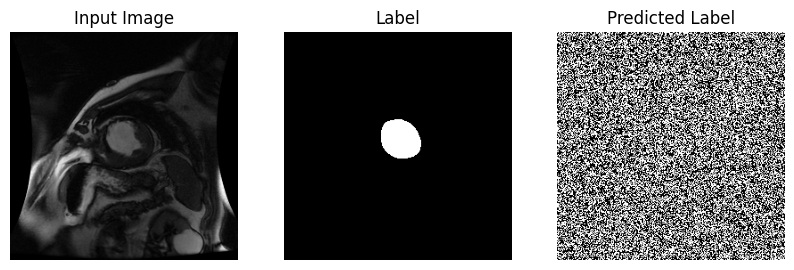


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 116s 476ms/step - accuracy: 0.5330 - loss: 0.6931 - val_accuracy: 0.5536 - val_loss: 0.6931
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/stepstep - accuracy: 0.5644 - loss: 0.69


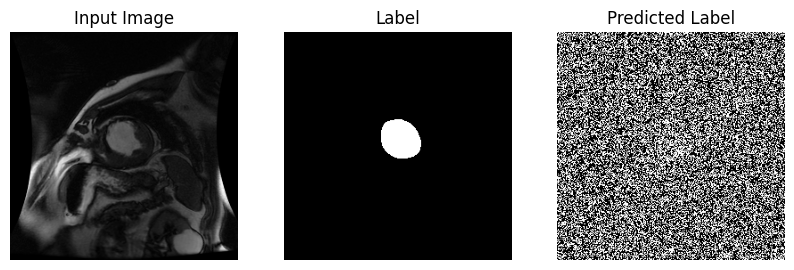


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 90s 328ms/step - accuracy: 0.5644 - loss: 0.6931 - val_accuracy: 0.6113 - val_loss: 0.6931
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepms/step - accuracy: 0.6377 - loss: 0.693


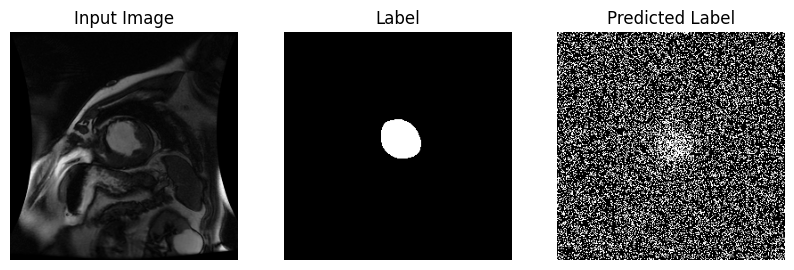


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 52s 221ms/step - accuracy: 0.6378 - loss: 0.6931 - val_accuracy: 0.7492 - val_loss: 0.6931
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/stepstep - accuracy: 0.8018 - loss: 0.69


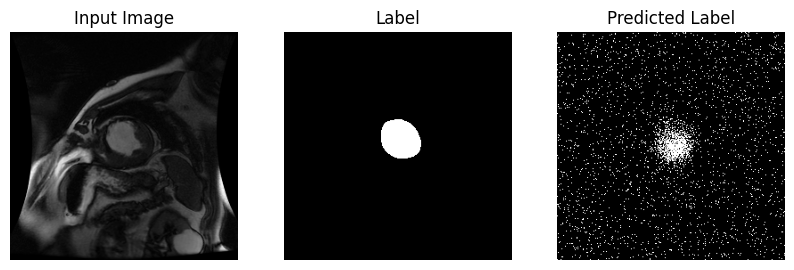


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 64s 274ms/step - accuracy: 0.8020 - loss: 0.6931 - val_accuracy: 0.9520 - val_loss: 0.6931
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/stepstep - accuracy: 0.9705 - loss: 0.69


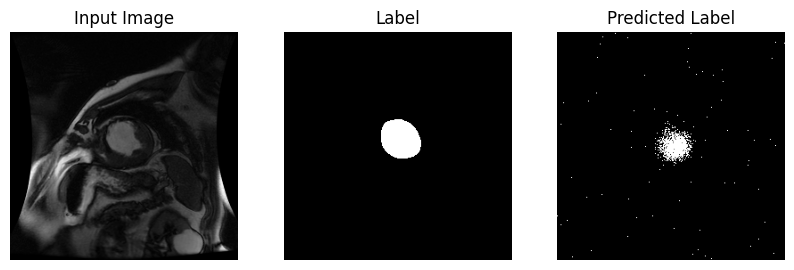


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 213s 913ms/step - accuracy: 0.9705 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/stepstep - accuracy: 0.9861 - loss: 0.69


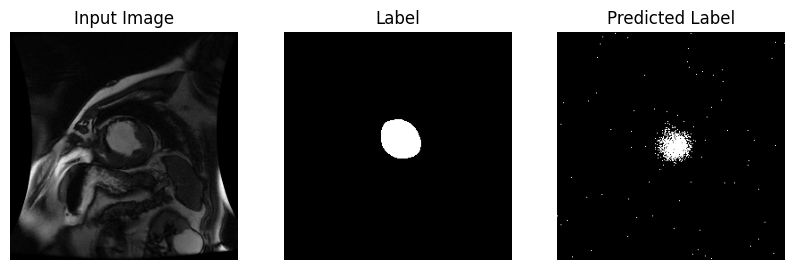


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 73s 287ms/step - accuracy: 0.9861 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/stepstep - accuracy: 0.9863 - loss: 0.693


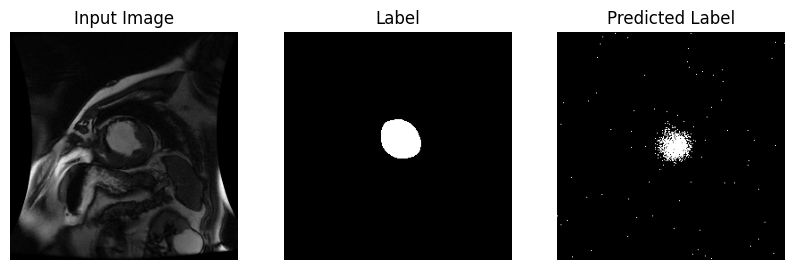


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step - accuracy: 0.9863 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/stepstep - accuracy: 0.9861 - loss: 0.693


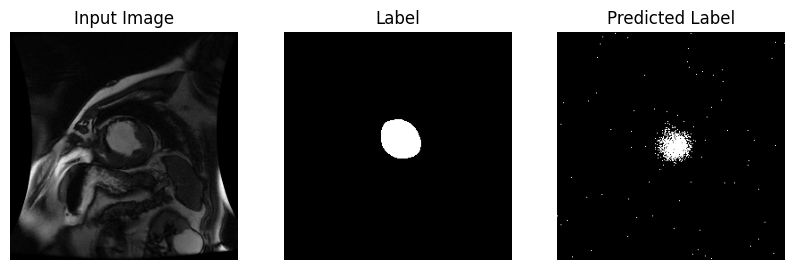


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.9861 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step/step - accuracy: 0.9861 - loss: 0.693


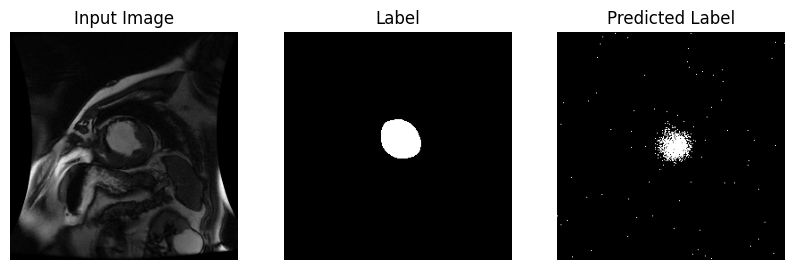


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9861 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step/step - accuracy: 0.9862 - loss: 0.693


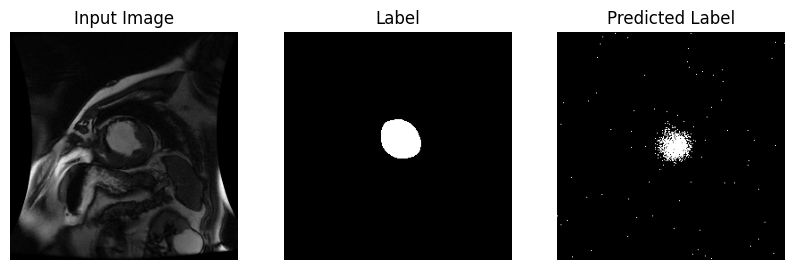


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step/step - accuracy: 0.9862 - loss: 0.693


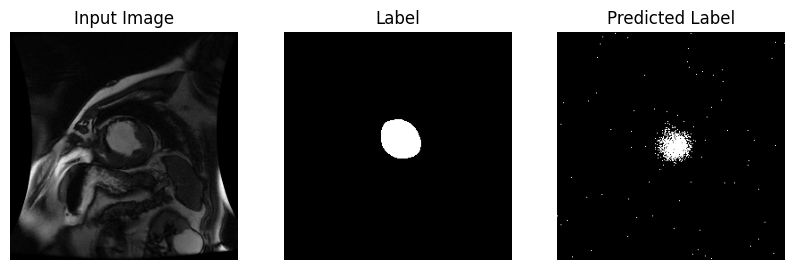


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/stepstep - accuracy: 0.9862 - loss: 0.69


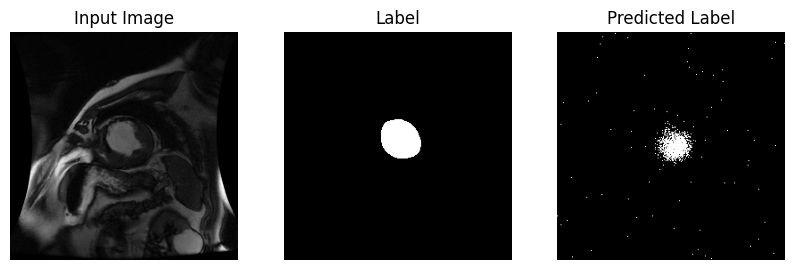


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/stepstep - accuracy: 0.9862 - loss: 0.69


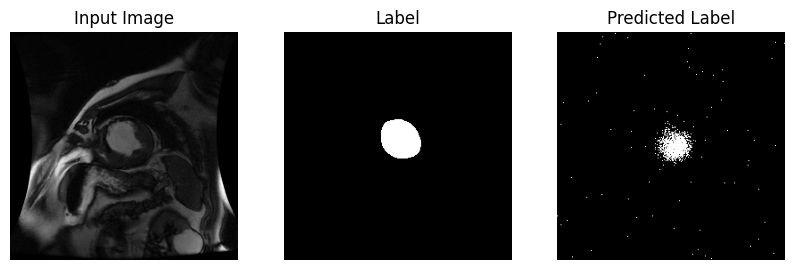


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step/step - accuracy: 0.9862 - loss: 0.693


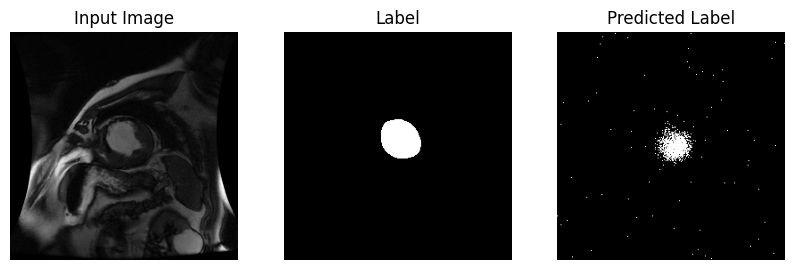


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stepstep - accuracy: 0.9863 - loss: 0.693


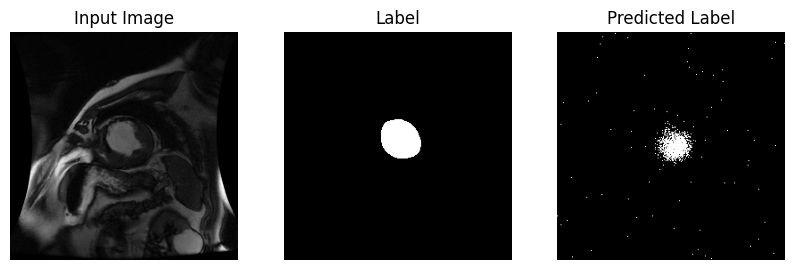


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.9863 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step/step - accuracy: 0.9862 - loss: 0.693


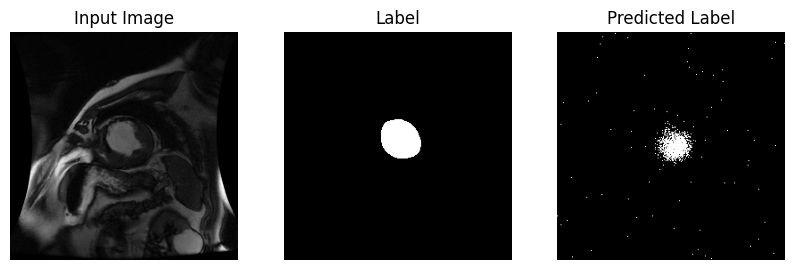


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step/step - accuracy: 0.9862 - loss: 0.693


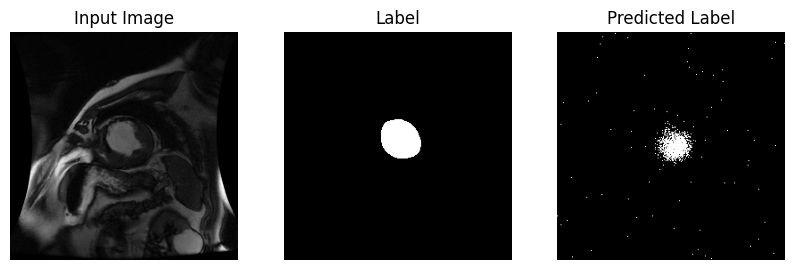


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step/step - accuracy: 0.9862 - loss: 0.693


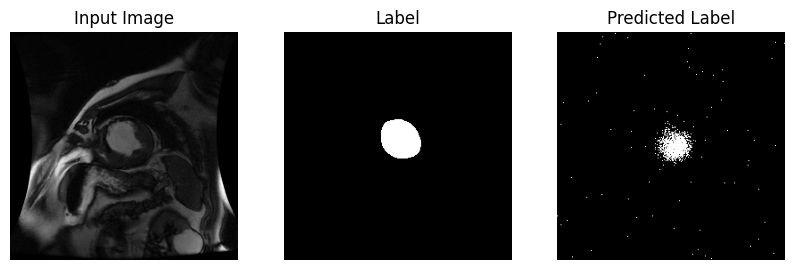


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 187ms/step - accuracy: 0.9862 - loss: 0.6931 - val_accuracy: 0.9854 - val_loss: 0.6931


In [20]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

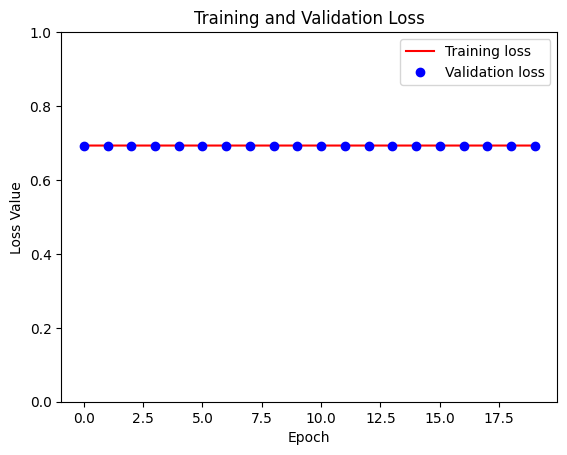

In [21]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Model Evaluation

In [22]:
model.evaluate(test_dataset)

     26/Unknown 0s 11ms/step - accuracy: 0.9839 - loss: 0.6931

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.9840 - loss: 0.6931


g:\Desktop\Project\LLMHobbyProjects\ImageSegmentation\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.6931402683258057, 0.9853979349136353]

In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


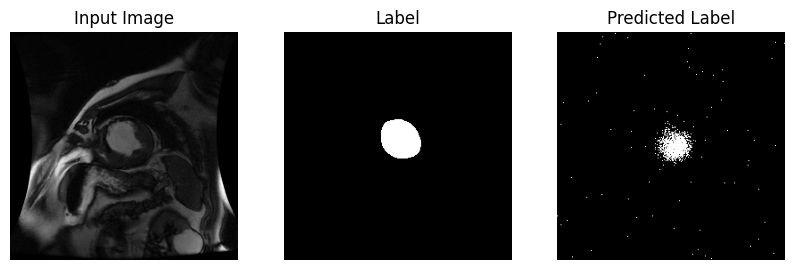

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


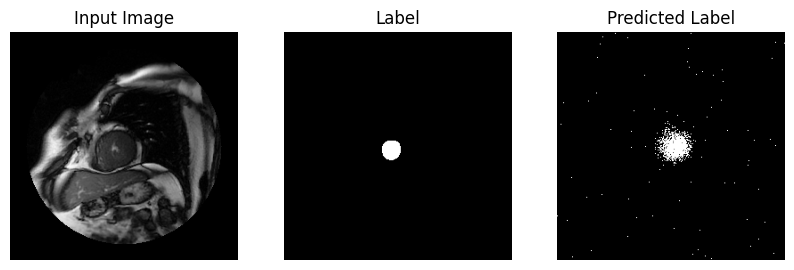

In [25]:
show_predictions(test_dataset, 2)

# Convolutional Neural Network (CNN)

In [26]:
tf.keras.backend.clear_session()

# set up the model architecture

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]


g:\Desktop\Project\LLMHobbyProjects\ImageSegmentation\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model = tf.keras.models.Sequential(layers)

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [29]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857,848 (7.09 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

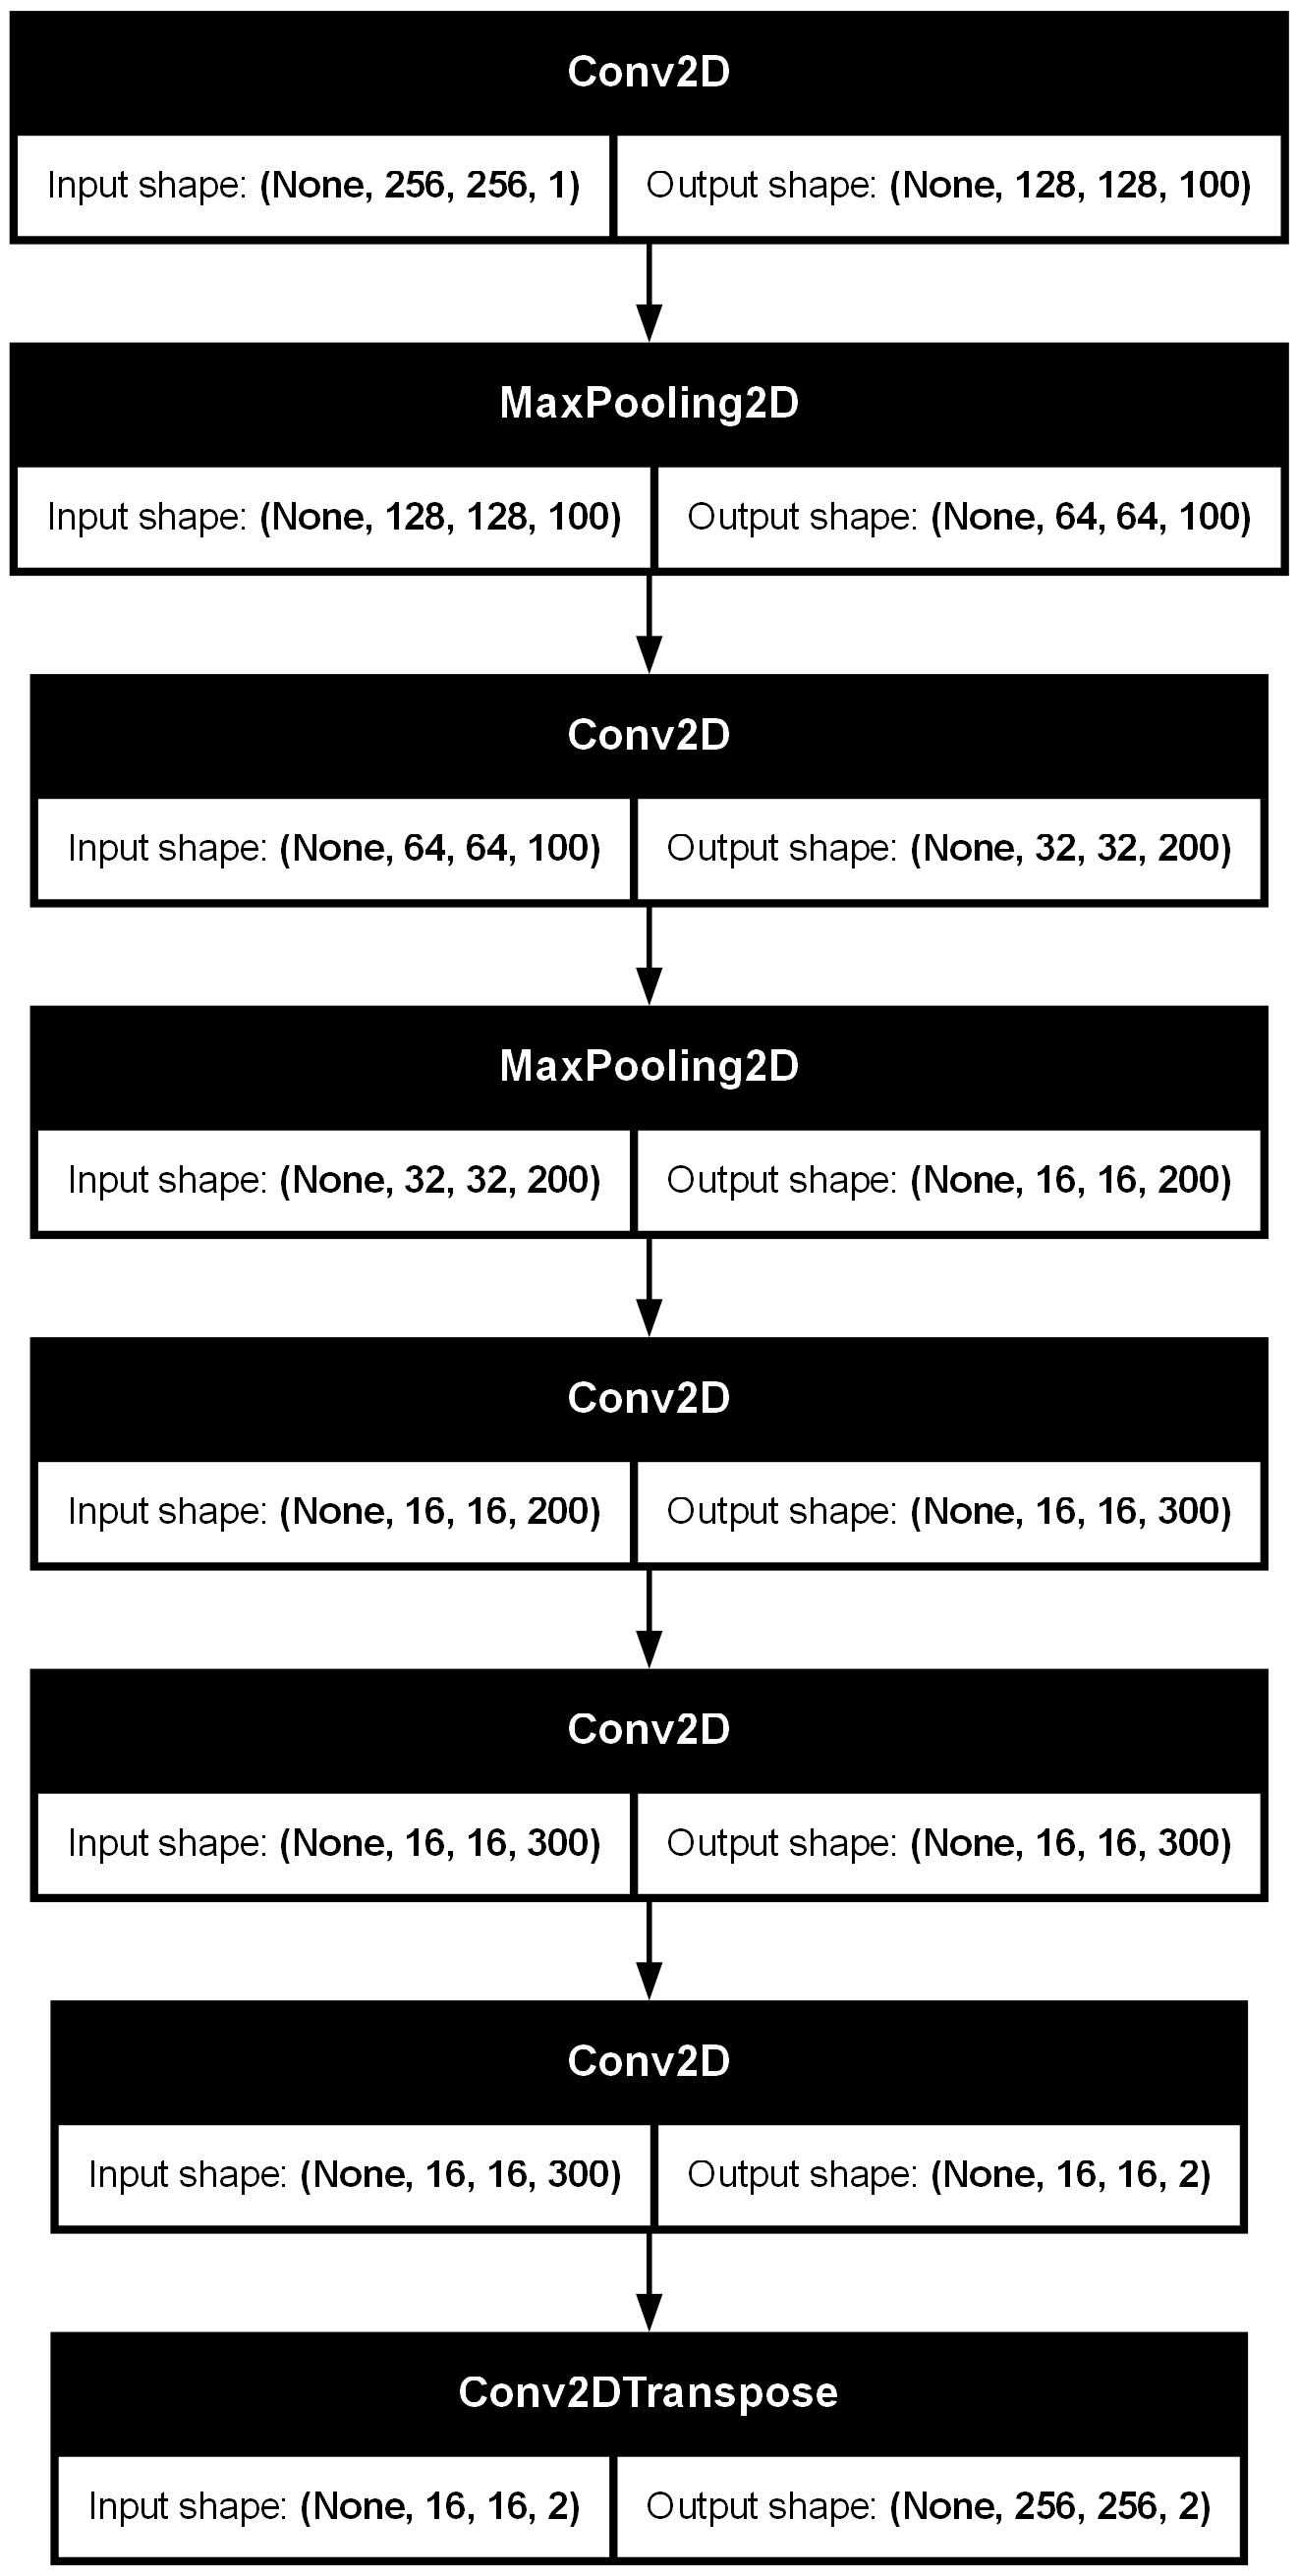

In [30]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


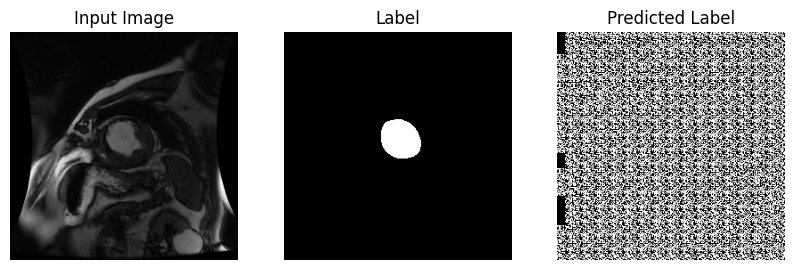

In [31]:
# show a predection, as an example
show_predictions(test_dataset)

In [32]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/stepstep - accuracy: 0.9723 - loss: 0.640


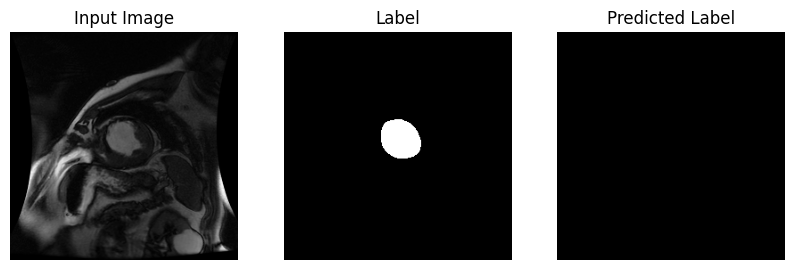


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.9723 - loss: 0.6406 - val_accuracy: 0.9830 - val_loss: 0.5037
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/stepstep - accuracy: 0.9844 - loss: 0.467


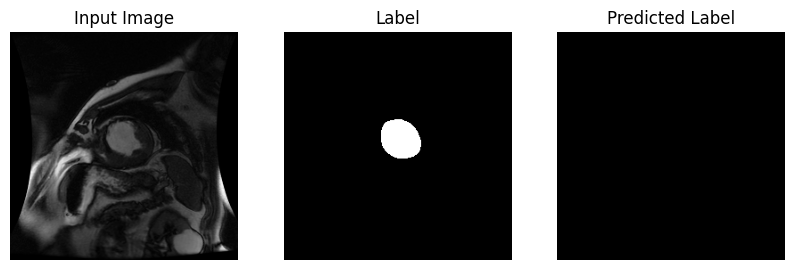


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9844 - loss: 0.4674 - val_accuracy: 0.9830 - val_loss: 0.3759
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/steptep - accuracy: 0.9848 - loss: 0.350


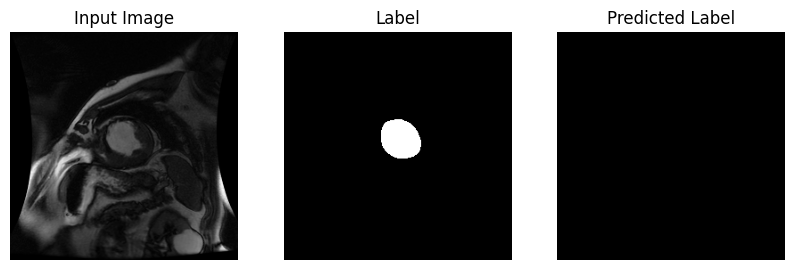


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9848 - loss: 0.3506 - val_accuracy: 0.9830 - val_loss: 0.2905
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9846 - loss: 0.272


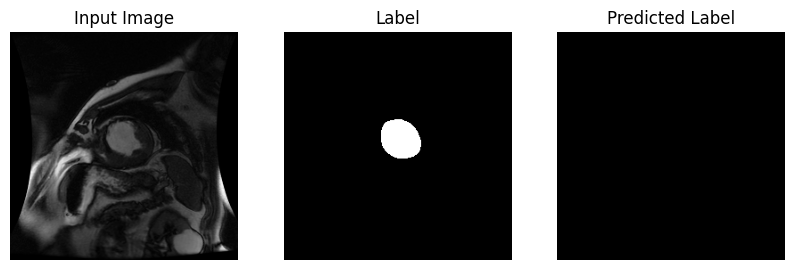


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9846 - loss: 0.2725 - val_accuracy: 0.9830 - val_loss: 0.2328
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/stepstep - accuracy: 0.9848 - loss: 0.219


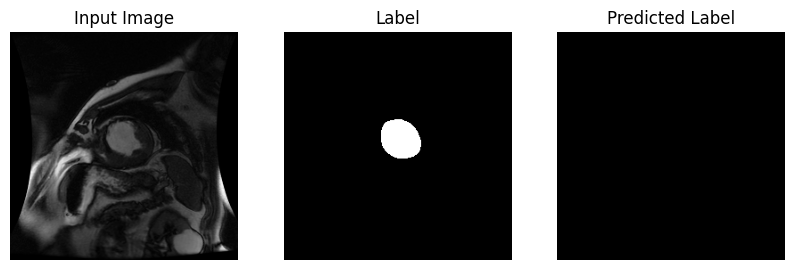


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9848 - loss: 0.2191 - val_accuracy: 0.9830 - val_loss: 0.1930
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/stepstep - accuracy: 0.9844 - loss: 0.182


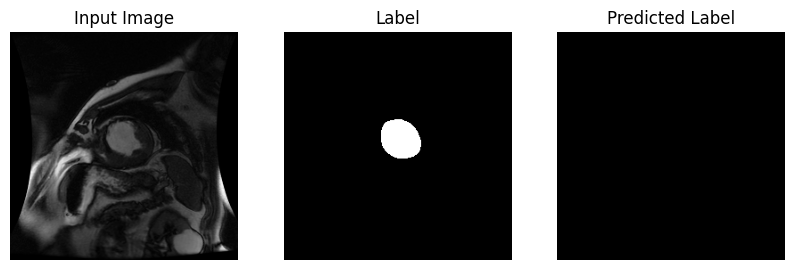


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.9844 - loss: 0.1827 - val_accuracy: 0.9830 - val_loss: 0.1650
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9845 - loss: 0.156


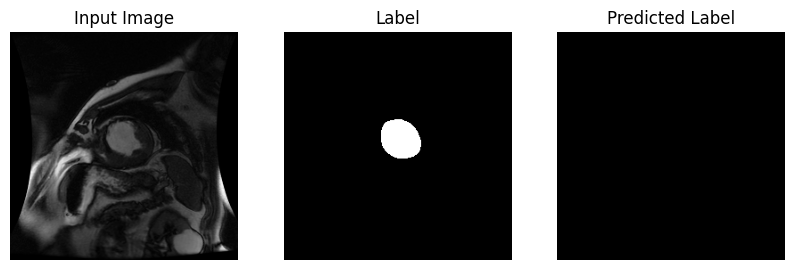


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9845 - loss: 0.1565 - val_accuracy: 0.9830 - val_loss: 0.1448
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/stepstep - accuracy: 0.9845 - loss: 0.137


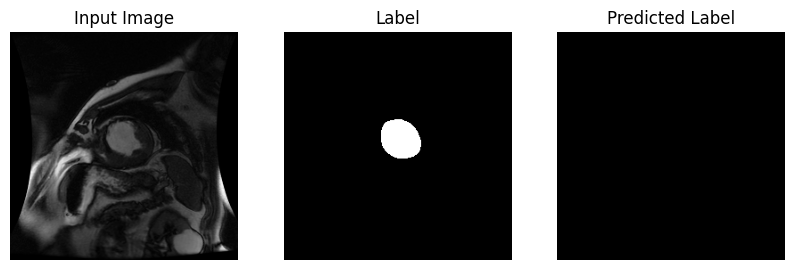


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9845 - loss: 0.1374 - val_accuracy: 0.9830 - val_loss: 0.1301
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9847 - loss: 0.123


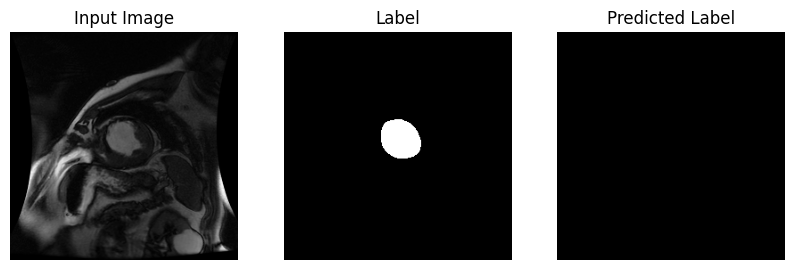


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9847 - loss: 0.1230 - val_accuracy: 0.9830 - val_loss: 0.1192
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9846 - loss: 0.112


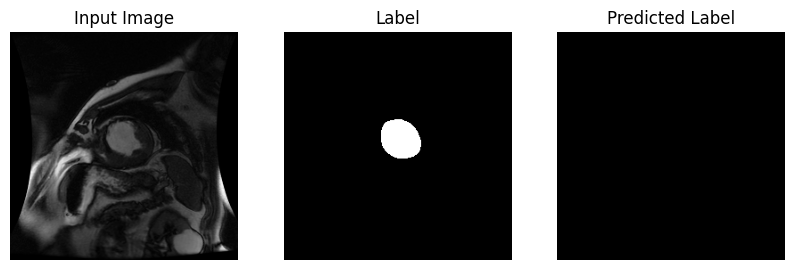


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9846 - loss: 0.1128 - val_accuracy: 0.9830 - val_loss: 0.1110
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepstep - accuracy: 0.9848 - loss: 0.104


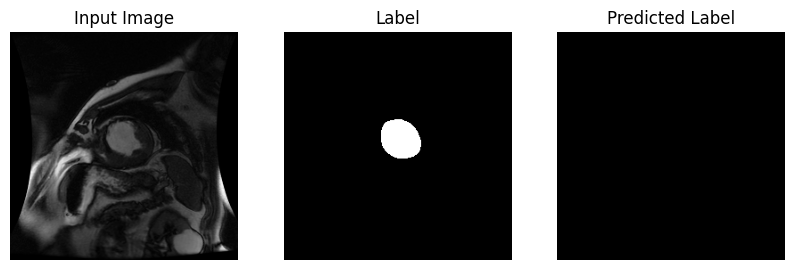


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9847 - loss: 0.1045 - val_accuracy: 0.9830 - val_loss: 0.1049
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepstep - accuracy: 0.9844 - loss: 0.099


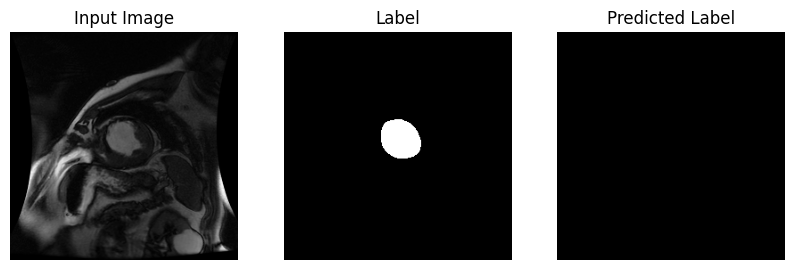


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9844 - loss: 0.0993 - val_accuracy: 0.9830 - val_loss: 0.1002
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepstep - accuracy: 0.9846 - loss: 0.094


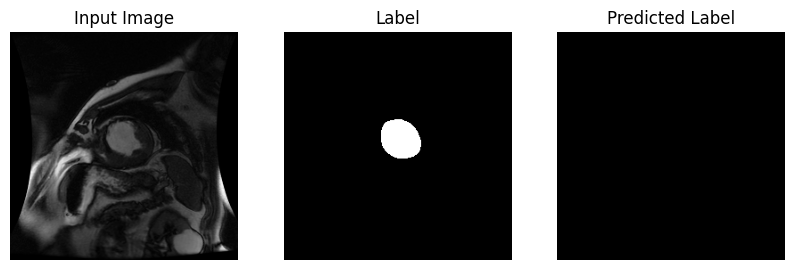


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9846 - loss: 0.0943 - val_accuracy: 0.9830 - val_loss: 0.0966
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepstep - accuracy: 0.9849 - loss: 0.089


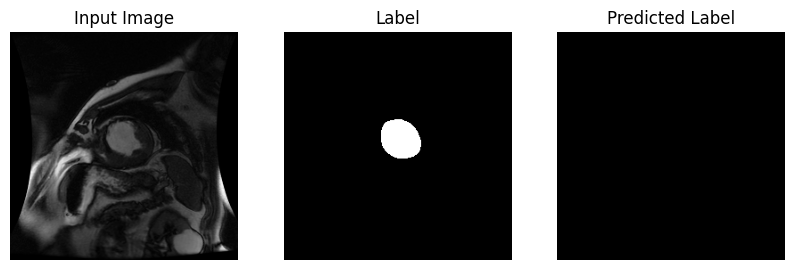


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9849 - loss: 0.0897 - val_accuracy: 0.9830 - val_loss: 0.0939
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepstep - accuracy: 0.9848 - loss: 0.087


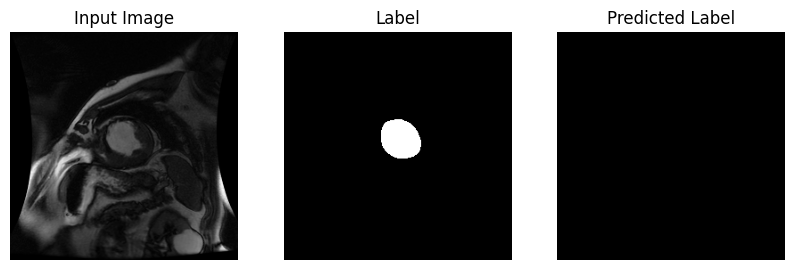


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9848 - loss: 0.0873 - val_accuracy: 0.9830 - val_loss: 0.0918
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/stepstep - accuracy: 0.9844 - loss: 0.086


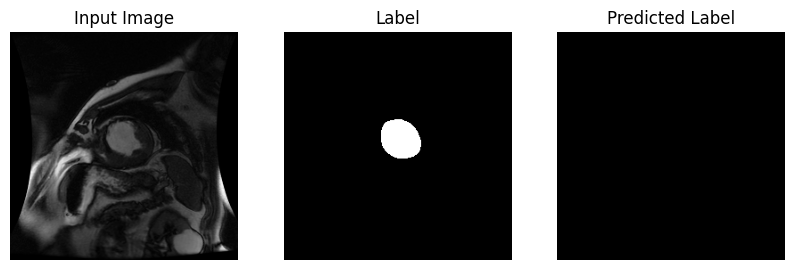


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9844 - loss: 0.0865 - val_accuracy: 0.9830 - val_loss: 0.0902
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepstep - accuracy: 0.9846 - loss: 0.084


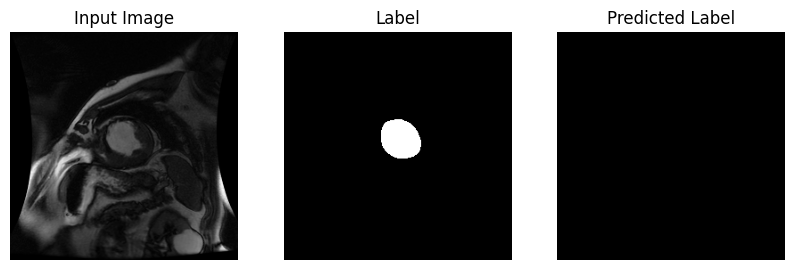


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9846 - loss: 0.0841 - val_accuracy: 0.9830 - val_loss: 0.0890
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9848 - loss: 0.082


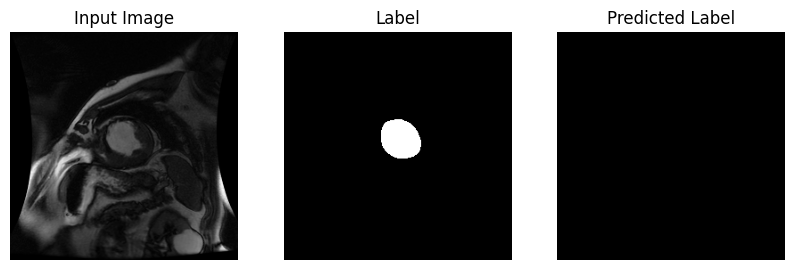


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9848 - loss: 0.0824 - val_accuracy: 0.9830 - val_loss: 0.0882
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepstep - accuracy: 0.9847 - loss: 0.081


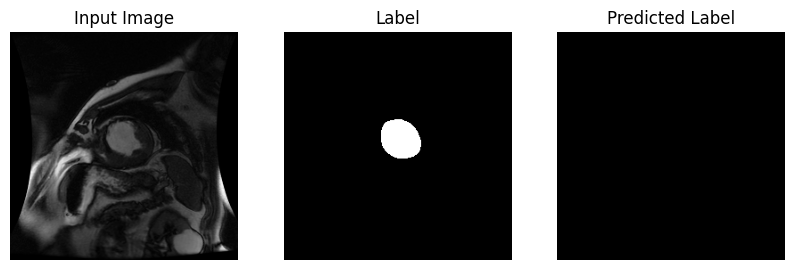


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9847 - loss: 0.0816 - val_accuracy: 0.9830 - val_loss: 0.0875
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9847 - loss: 0.081


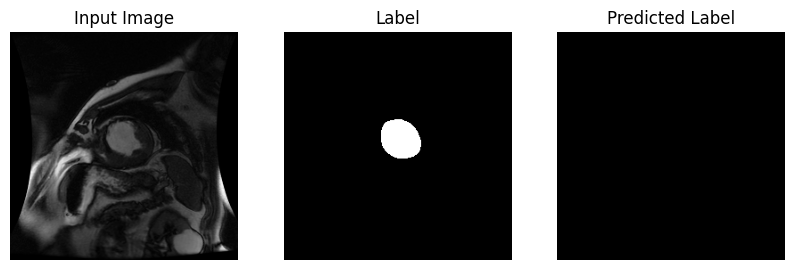


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9847 - loss: 0.0811 - val_accuracy: 0.9830 - val_loss: 0.0871


In [33]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

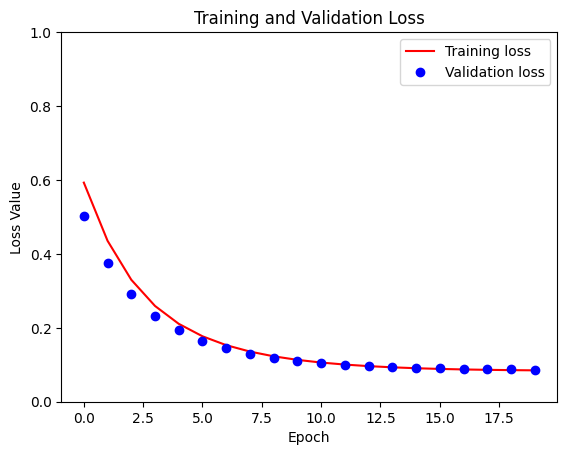

In [34]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [35]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9796 - loss: 0.0997


[0.08710212260484695, 0.9829577207565308]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


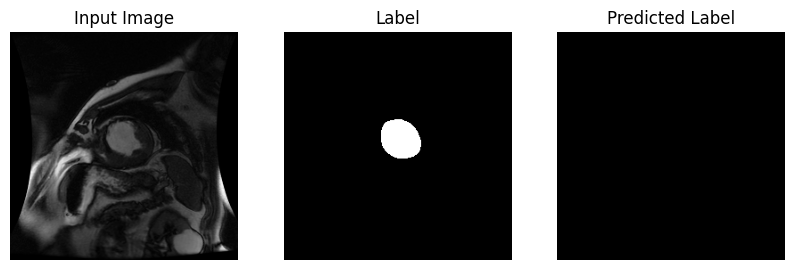

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


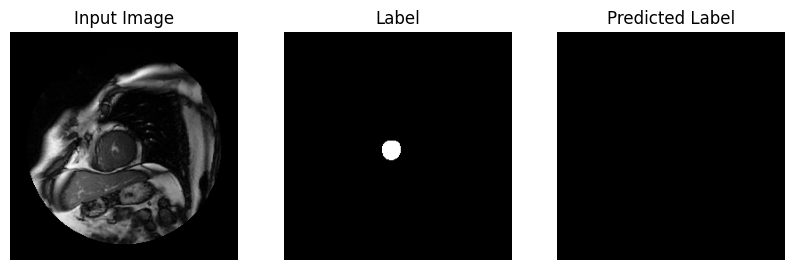

In [37]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 2)

# Accuracy

In [38]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [39]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [40]:
tf.keras.backend.clear_session() 
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

In [ ]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Parameter Search